In [1]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from imblearn.under_sampling import OneSidedSelection, TomekLinks, EditedNearestNeighbours

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('../datasets/BankChurners_change.csv', encoding='CP949')
data = data.iloc[:,2:23]
np.random.seed(42)
random.seed(42)

In [3]:
import tensorflow as tf

def metric_precision(y_true,y_pred): 
 TP=tf.reduce_sum(y_true*tf.round(y_pred))
 TN=tf.reduce_sum((1-y_true)*(1-tf.round(y_pred)))
 FP=tf.reduce_sum((1-y_true)*tf.round(y_pred))
 FN=tf.reduce_sum(y_true*(1-tf.round(y_pred)))
 precision=TP/(TP+FP)
 return precision

def metric_recall(y_true,y_pred): 
 TP=tf.reduce_sum(y_true*tf.round(y_pred))
 TN=tf.reduce_sum((1-y_true)*(1-tf.round(y_pred)))
 FP=tf.reduce_sum((1-y_true)*tf.round(y_pred))
 FN=tf.reduce_sum(y_true*(1-tf.round(y_pred)))
 recall=TP/(TP+FN)
 return recall

#F1-score    
def metric_F1score(y_true,y_pred): 
 TP=tf.reduce_sum(y_true*tf.round(y_pred))
 TN=tf.reduce_sum((1-y_true)*(1-tf.round(y_pred)))
 FP=tf.reduce_sum((1-y_true)*tf.round(y_pred))
 FN=tf.reduce_sum(y_true*(1-tf.round(y_pred)))
 precision=TP/(TP+FP)
 recall=TP/(TP+FN)
 F1score=2*precision*recall/(precision+recall)
 return F1score

In [4]:
object_columns = data.select_dtypes('object').columns

for i in object_columns:

    lb = LabelEncoder()
    lb.fit(data[i])
    data[i] = lb.transform(data[i])
    
    print(f'category : {np.unique(data[i])}\nclasses : {lb.classes_}\n')

input = data.iloc[:,1:]
target = data.iloc[:,0]

category : [0 1]
classes : ['Attrited Customer' 'Existing Customer']

category : [0 1]
classes : ['F' 'M']

category : [0 1 2 3 4 5 6]
classes : ['College' 'Doctorate' 'Graduate' 'High School' 'Post-Graduate'
 'Uneducated' 'Unknown']

category : [0 1 2 3]
classes : ['Divorced' 'Married' 'Single' 'Unknown']

category : [0 1 2 3 4 5]
classes : ['$120K +' '$40K - $60K' '$60K - $80K' '$80K - $120K' 'Less than $40K'
 'Unknown']

category : [0 1 2 3]
classes : ['Blue' 'Gold' 'Platinum' 'Silver']

category : [0 1 2 3 4]
classes : ['20대' '30대' '40대' '50대' '60대 이상']



## onesideselection

In [5]:
x_train, x_test, y_train, y_test = train_test_split(input, target, random_state=42, test_size=0.2)

ss = StandardScaler()
x_train = ss.fit_transform(x_train)
x_test = ss.fit_transform(x_test)

oss = OneSidedSelection(random_state=42)
x_train, y_train = oss.fit_resample(x_train, y_train)

In [9]:
model = Sequential()

model.add(keras.Input(shape=(20,)))

model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))

model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(BatchNormalization())
model.add(Dense(32, activation='relu'))

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
	 loss='binary_crossentropy',
	 metrics=['accuracy',
	 		metric_precision,
	 		metric_recall,
	 		metric_F1score,
			 ])
            
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_6 (Batc  (None, 20)               80        
 hNormalization)                                                 
                                                                 
 dense_8 (Dense)             (None, 128)               2688      
                                                                 
 batch_normalization_7 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dense_9 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 batch_normalization_8 (Batc  (None, 64)              

In [10]:
import os
from keras.callbacks import ModelCheckpoint, EarlyStopping

MODEL_DIR = './model/'
if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)

modelpath = './model/{epoch:02d}-{val_loss:4f}.hdf5'
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100,
batch_size=32, verbose=0, callbacks=[early_stopping_callback, checkpointer])

print('\n Test F1 Score : %.4f' % (model.evaluate(x_test, y_test)[4]))


Epoch 1: val_loss improved from inf to 0.26356, saving model to ./model\01-0.263557.hdf5

Epoch 2: val_loss improved from 0.26356 to 0.22266, saving model to ./model\02-0.222662.hdf5

Epoch 3: val_loss improved from 0.22266 to 0.19952, saving model to ./model\03-0.199520.hdf5

Epoch 4: val_loss improved from 0.19952 to 0.17497, saving model to ./model\04-0.174967.hdf5

Epoch 5: val_loss improved from 0.17497 to 0.17052, saving model to ./model\05-0.170519.hdf5

Epoch 6: val_loss did not improve from 0.17052

Epoch 7: val_loss improved from 0.17052 to 0.16667, saving model to ./model\07-0.166668.hdf5

Epoch 8: val_loss improved from 0.16667 to 0.16457, saving model to ./model\08-0.164574.hdf5

Epoch 9: val_loss did not improve from 0.16457

Epoch 10: val_loss improved from 0.16457 to 0.16416, saving model to ./model\10-0.164160.hdf5

Epoch 11: val_loss improved from 0.16416 to 0.15966, saving model to ./model\11-0.159664.hdf5

Epoch 12: val_loss did not improve from 0.15966

Epoch 13: 

In [11]:
pred = model.predict(x_test)
pred

array([[0.99840975],
       [0.9999931 ],
       [0.99024904],
       ...,
       [0.9973162 ],
       [0.96631575],
       [0.9937885 ]], dtype=float32)

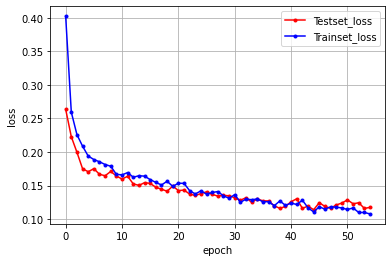

In [12]:
# 테스트 셋의 오차
y_vloss = history.history['val_loss']

# 학습셋의 오차
y_loss = history.history["loss"]

# 그래프로 표현
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker=".", c="red", label="Testset_loss")
plt.plot(x_len, y_loss, marker=".", c="blue", label="Trainset_loss")

# 그래프에 그리드를 주고 레이블을 표시
plt.legend()
plt.grid()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

------------

---------------------

## sampling X

In [13]:
x_train, x_test, y_train, y_test = train_test_split(input, target, random_state=42, test_size=0.2)

ss = StandardScaler()
x_train = ss.fit_transform(x_train)
x_test = ss.fit_transform(x_test)

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(8101, 20) (2026, 20) (8101,) (2026,)


In [15]:
model = Sequential()

model.add(keras.Input(shape=(20,)))

model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))

model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(BatchNormalization())
model.add(Dense(32, activation='relu'))

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
	 loss='binary_crossentropy',
	 metrics=['accuracy',
	 		metric_precision,
	 		metric_recall,
	 		metric_F1score,
			 ])
            
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_12 (Bat  (None, 20)               80        
 chNormalization)                                                
                                                                 
 dense_16 (Dense)            (None, 128)               2688      
                                                                 
 batch_normalization_13 (Bat  (None, 128)              512       
 chNormalization)                                                
                                                                 
 dense_17 (Dense)            (None, 64)                8256      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 batch_normalization_14 (Bat  (None, 64)              

In [16]:
import os
from keras.callbacks import ModelCheckpoint, EarlyStopping

MODEL_DIR = './model/'
if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)

modelpath = './model/{epoch:02d}-{val_loss:4f}.hdf5'
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100,
batch_size=32, verbose=0, callbacks=[early_stopping_callback, checkpointer])

print('\n Test F1 Score : %.4f' % (model.evaluate(x_test, y_test)[4]))


Epoch 1: val_loss improved from inf to 0.25288, saving model to ./model\01-0.252878.hdf5

Epoch 2: val_loss improved from 0.25288 to 0.21087, saving model to ./model\02-0.210867.hdf5

Epoch 3: val_loss improved from 0.21087 to 0.19707, saving model to ./model\03-0.197067.hdf5

Epoch 4: val_loss improved from 0.19707 to 0.18989, saving model to ./model\04-0.189893.hdf5

Epoch 5: val_loss improved from 0.18989 to 0.18386, saving model to ./model\05-0.183864.hdf5

Epoch 6: val_loss improved from 0.18386 to 0.17128, saving model to ./model\06-0.171278.hdf5

Epoch 7: val_loss improved from 0.17128 to 0.17116, saving model to ./model\07-0.171157.hdf5

Epoch 8: val_loss improved from 0.17116 to 0.16577, saving model to ./model\08-0.165771.hdf5

Epoch 9: val_loss improved from 0.16577 to 0.15949, saving model to ./model\09-0.159485.hdf5

Epoch 10: val_loss did not improve from 0.15949

Epoch 11: val_loss improved from 0.15949 to 0.15643, saving model to ./model\11-0.156426.hdf5

Epoch 12: val

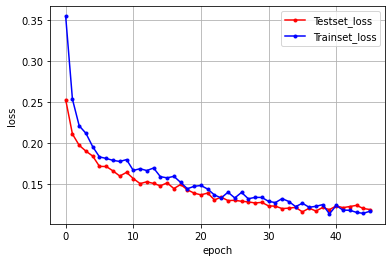

In [17]:
# 테스트 셋의 오차
y_vloss = history.history['val_loss']

# 학습셋의 오차
y_loss = history.history["loss"]

# 그래프로 표현
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker=".", c="red", label="Testset_loss")
plt.plot(x_len, y_loss, marker=".", c="blue", label="Trainset_loss")

# 그래프에 그리드를 주고 레이블을 표시
plt.legend()
plt.grid()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

##### BatchNormalization https://eehoeskrap.tistory.com/430